In [6]:
import math
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (13, 4)

torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

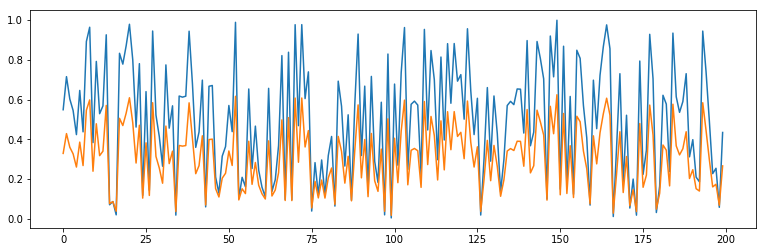

In [7]:
source = np.random.rand(100000)
target = [ (x**2 + x**0.5 + 0.5*x)/4 for x in source]

sample_size = 200
plt.plot(source[:sample_size])
plt.plot(target[:sample_size])
plt.show()

In [8]:
df = pd.DataFrame({"source": source, "target": target})
df.to_csv("sample_data.csv", index=False)

In [9]:
status = [ x>0.2 for x in target]

In [10]:
import torch.utils.data as data_utils

class NILMDataset(data_utils.Dataset):
    def __init__(self, x, y, status, window_size=480, stride=30):
        self.x = x
        self.y = y
        self.status = status
        self.window_size = window_size
        self.stride = stride

    def __len__(self):
        return int(np.ceil((len(self.x) - self.window_size) / self.stride) + 1)

    def __getitem__(self, index):
        start_index = index * self.stride
        end_index = np.min(
            (len(self.x), index * self.stride + self.window_size))
        x = self.padding_seqs(self.x[start_index: end_index])
        y = self.padding_seqs(self.y[start_index: end_index])
        status = self.padding_seqs(self.status[start_index: end_index])
        return torch.tensor(x), torch.tensor(y), torch.tensor(status)

    def padding_seqs(self, in_array):
        if len(in_array) == self.window_size:
            return in_array
        try:
            out_array = np.zeros((self.window_size, in_array.shape[1]))
        except:
            out_array = np.zeros(self.window_size)

        length = len(in_array)
        out_array[:length] = in_array
        return out_array


In [11]:
dataset = NILMDataset(x=source, y=target, status=status)
len(source), len(dataset)

(100000, 3319)

In [12]:
s = dataset.__getitem__(3319)
s[0].size(), s[1].size(), s[2].size()

(torch.Size([480]), torch.Size([480]), torch.Size([480]))

In [13]:
class NILMDataloader():
    def __init__(self):
        
        self.batch_size = 50
        window_stride = 30
        val_size = 0.2
        x = source
        y = target
        window_size = 480
        val_end = int(val_size * len(source))
        val = NILMDataset(x[:val_end], y[:val_end], status[:val_end], window_size, window_size)
        train = NILMDataset(x[val_end:], y[val_end:], status[val_end:], window_size, window_stride)

        self.train_dataset = train 
        self.val_dataset = val

    def get_dataloaders(self):
        train_loader = self._get_loader(self.train_dataset)
        val_loader = self._get_loader(self.val_dataset)
        return train_loader, val_loader

    def _get_loader(self, dataset):
        dataloader = data_utils.DataLoader(
            dataset, batch_size=self.batch_size, shuffle=False, pin_memory=True)
        return dataloader


In [14]:
data_loader = NILMDataloader()
train_loader, val_loader = NILMDataloader().get_dataloaders()


In [17]:
for batch_ndx, sample in enumerate(train_loader):
    src, tgt, sts = sample
    print(src.size(), tgt.size())
    break

torch.Size([50, 480]) torch.Size([50, 480])


In [ ]:
def blockify(x, block_size: int):
    """image to blocks
    Args:
        x (Tensor): with shape (B, H, W, C)
        block_size (int): edge length of a single square block in units of H, W
    """
    B, H, W, C  = x.shape
    _assert(H % block_size == 0, '`block_size` must divide input height evenly')
    _assert(W % block_size == 0, '`block_size` must divide input width evenly')
    grid_height = H // block_size
    grid_width = W // block_size
    x = x.reshape(B, grid_height, block_size, grid_width, block_size, C)
    x = x.transpose(2, 3).reshape(B, grid_height * grid_width, -1, C)
    return x  # (B, T, N, C)

In [20]:
src = torch.unsqueeze(src, 1)
src = torch.unsqueeze(src, 3)

In [21]:
src.size()

torch.Size([50, 1, 480, 1])

In [27]:
def blockify_1D(x, block_size: int):
    """image to blocks
    Args:
        x (Tensor): with shape (B, 1, W, C)
        block_size (int): edge length of a single square block in units of W
    """
    B, H, W, C  = x.shape
    assert(H == 1),'It must be 1D tensor'
    assert(W % block_size == 0),'`block_size` must divide input width evenly'
    grid_height = 1
    grid_width = W // block_size
    x = x.reshape(B, grid_height, 1, grid_width, block_size, C)
    x = x.transpose(2, 3).reshape(B, grid_height * grid_width, -1, C)
    return x  # (B, T, N, C)

blockify_1D(src, 10).size()

torch.Size([50, 48, 10, 1])

In [ ]:
def deblockify(x, block_size: int):
    """blocks to image
    Args:
        x (Tensor): with shape (B, T, N, C) where T is number of blocks and N is sequence size per block
        block_size (int): edge length of a single square block in units of desired H, W
    """
    B, T, _, C = x.shape
    grid_size = int(math.sqrt(T))
    height = width = grid_size * block_size
    x = x.reshape(B, grid_size, grid_size, block_size, block_size, C)
    x = x.transpose(2, 3).reshape(B, height, width, C)
    return x  # (B, H, W, C)